In [1]:
# Usual suspect
import numpy as np
import sys
import math
import pandas as pd
from typing import Tuple
sys.path.insert(1, '../muograph')

%reload_ext autoreload
%autoreload 2

# **Muon hits**

In [2]:
from hits.hits import Hits

def get_hits_in_out_from_csv_file(csv_file: str) -> Tuple[Hits, Hits]:

    df = pd.read_csv(csv_file)

    # Get incoming and outgoing muon hits
    cols_in = [col for col in df.columns for label in [0, 1, 2] if str(label) in col] + ["E"]
    cols_out = [col for col in df.columns for label in [3, 4, 5] if str(label) in col] + ["E"]

    # Get hits
    from hits.hits import Hits
    hits_in, hits_out = Hits(df = df[cols_in][:]), Hits(df = df[cols_out][:])

    return hits_in, hits_out

# **Tracking**


In [3]:
hits_in, hits_out = get_hits_in_out_from_csv_file("../data/1M_gen_2hods_30cm_panel_gap_barrel_voi.csv")

output_dir = "../output/test/"

from tracking.tracking import Tracking
tracks_in = Tracking(hits = hits_in, label = "above", output_dir=output_dir)
tracks_out = Tracking(hits = hits_out, label = "below", output_dir=output_dir)


../output/test directory already exists
Class attributes saved at ../output/test/tracks_above.hdf5

../output/test directory already exists
Class attributes saved at ../output/test/tracks_below.hdf5


In [4]:
from tracking.tracking import TrackingMST

# Load from tracking files
tracking_files = [
    str(tracks_in.output_dir / "tracks_above.hdf5"),
    str(tracks_out.output_dir / "tracks_below.hdf5")
]
mst = TrackingMST(tracking_files = tracking_files)

# Load from tracking instances
mst = TrackingMST(trackings=(tracks_in, tracks_out))


/home/geant/Desktop/TASKS/Muograph/MuographBeta/examples/../output directory already exists

Tracking attributes loaded from ../output/test/tracks_above.hdf5

Tracking attributes loaded from ../output/test/tracks_below.hdf5

/home/geant/Desktop/TASKS/Muograph/MuographBeta/examples/../output directory already exists


# **Reconstruction**

**Angle Statistic Reconstruction**

In [6]:
from volume.volume import Volume
voi = Volume(position = [0,0,-1200],dimension=[1000,600,600],voxel_width=20)

In [15]:
from reconstruction.asr import ASR
asr = ASR(voi=voi, tracking=mst, output_dir=output_dir)


../output/test directory already exists

Sub-volumes



Voxel triggering



Assigning voxels score


Compute final score


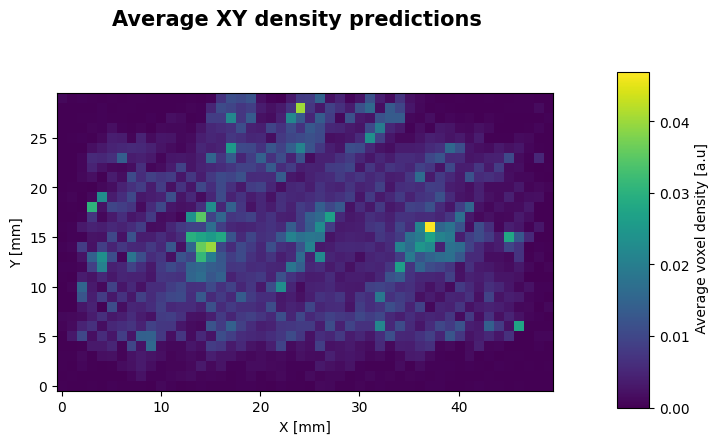

In [ ]:
from functools import partial 

asr.asr_params = {
        "score_method": partial(np.quantile, q=0.4),
        "p_range": (0.0, 10000000),  # MeV
        "dtheta_range": (0.5 * math.pi / 180, math.pi / 3),
        "use_p": False,
    }

from plotting.plotting import plot_density_pred
plot_density_pred(asr.density_pred, dim=2)
plot_density_pred(asr.density_pred, dim=1)
plot_density_pred(asr.density_pred, dim=0)


**Point Of Closest Approach**

In [7]:
from reconstruction.poca import POCA
poca = POCA(tracking = mst, voi=voi, output_dir=output_dir)


../output/test directory already exists

Assigning voxel to each POCA point:


Class attributes saved at ../output/test/poca.hdf5


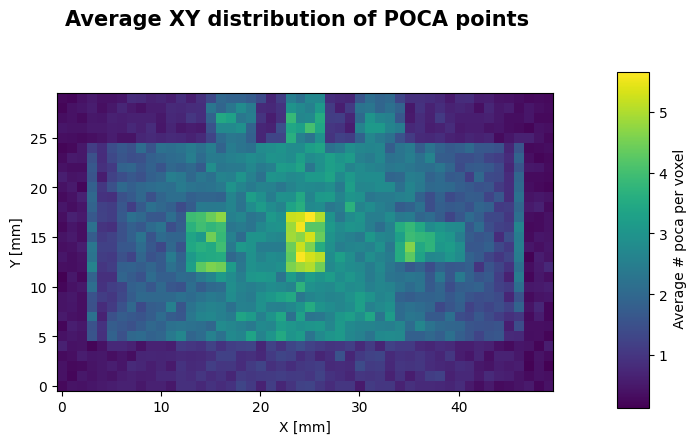

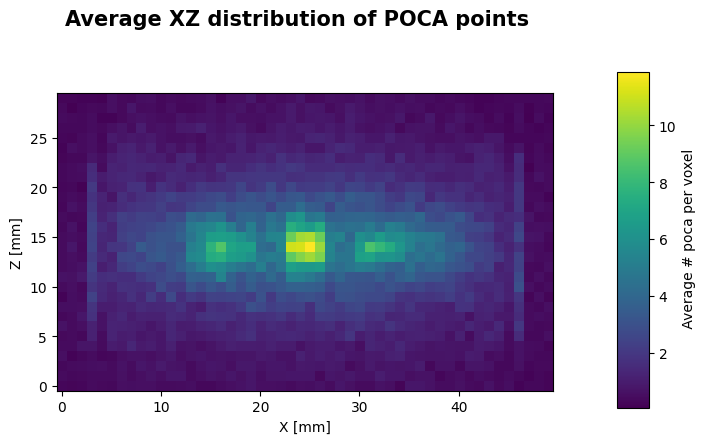

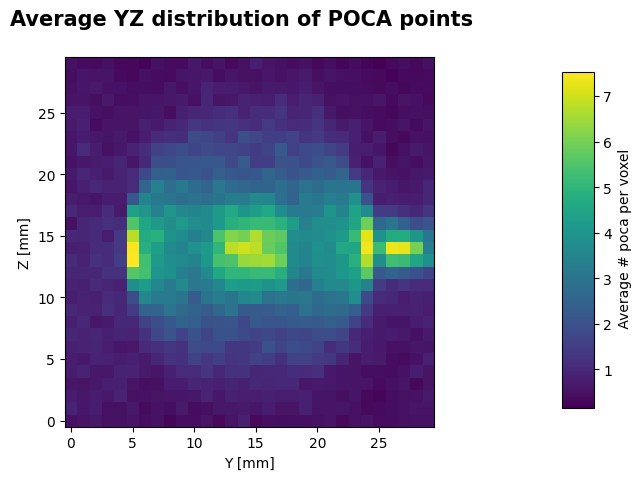

In [8]:
from plotting.plotting import plot_n_poca_per_voxel
plot_n_poca_per_voxel(poca.n_poca_per_vox, dim = 2)
plot_n_poca_per_voxel(poca.n_poca_per_vox, dim = 1)
plot_n_poca_per_voxel(poca.n_poca_per_vox, dim = 0)


**Binned Clustered Algorithm**

In [9]:
from reconstruction.binned_clustered import BCA

bca = BCA(voi = voi, tracking = mst, output_dir=output_dir)


/home/geant/Desktop/TASKS/Muograph/MuographBeta/examples/../output directory already exists
Class attributes saved at /home/geant/Desktop/TASKS/Muograph/MuographBeta/examples/../output/poca.hdf5

Assigning voxel to each POCA point:


In [14]:
from functools import partial

bca.bca_reconstruction(
    n_max_per_vox=20, 
    n_min_per_vox=4, 
    score_method = partial(np.quantile, q=0.5),
    metric_method = partial(np.log),
    p_range = (0, 1000000),
    dtheta_range=(0.1 * math.pi / 180, 10 * math.pi / 180))


/home/geant/Desktop/TASKS/Muograph/MuographBeta/examples/../output/method_quantile_q=0.5_metric_log_0.00_0.17_rad_0_1000000_MeV_n_min_max_4_20_use_p_False directory created


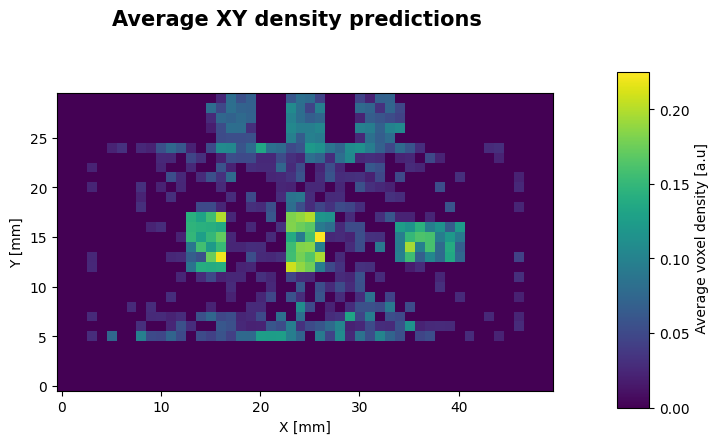

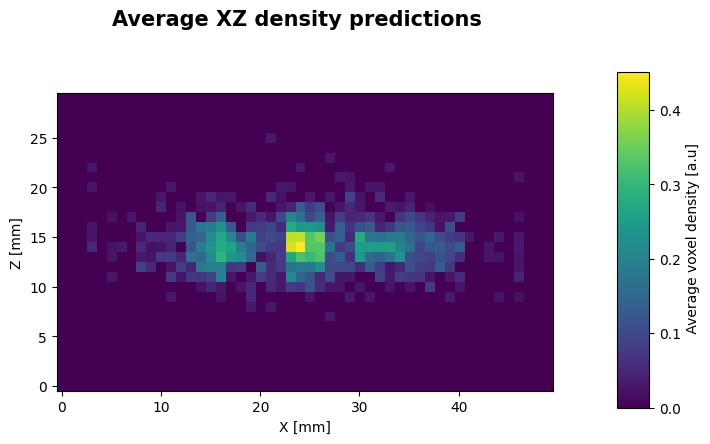

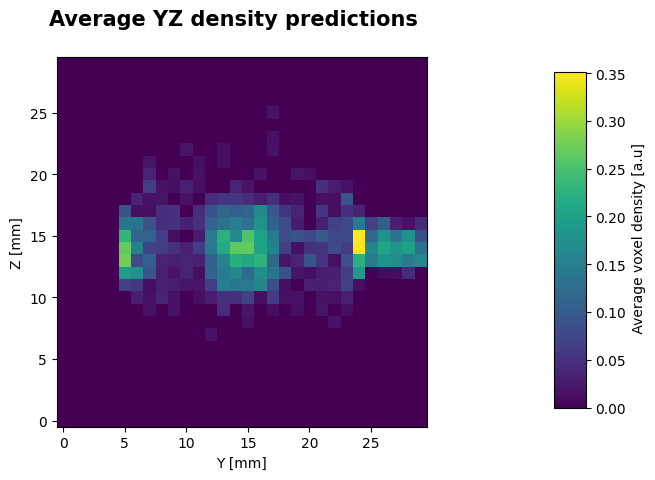

In [15]:
from plotting.plotting import plot_voxel_pred
plot_voxel_pred(bca.pred_norm, dim=2)
plot_voxel_pred(bca.pred_norm, dim=1)
plot_voxel_pred(bca.pred_norm, dim=0)